In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/final.csv")
df

,Unnamed: 0,url,type,type_encoded
0,0,https://mitsui-jyuku.mixh.jp/uploads/6343fvase...,malware,2
1,1,http://vbncdfaewoi.ug/az2.exe,malware,2
2,2,http://www.pensiiilfov.ro/index.php?option=com...,defacement,1
3,3,williameworkman.com/,benign,0
4,4,http://archive.salisburyjournal.co.uk/2000/8/3...,spam,4
...,...,...,...,...
472869,472869,news.cnet.com/2100-1023-245263.html,phishing,3
472870,472870,http://saglikramazan20bgb.net/20gb_hediye_inte...,malware,2
472871,472871,http://www.icci.com.br/index.php?option=com_k2...,defacement,1
472872,472872,http://www.niobestudio.com/index.php/component...,defacement,1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
# df = pd.read_csv("../data/final.csv")

# Identify duplicates based on the 'url' column
duplicates = df[df.duplicated(subset=['url'], keep=False)]  # All duplicate rows
unique_df = df.drop(duplicates.index)  # Remove them from the unique dataset

# Split only the unique data
train_unique, test_df = train_test_split(unique_df, test_size=0.2, stratify=unique_df['type_encoded'], random_state=42)

# Add all duplicates to the training set
train_df = pd.concat([train_unique, duplicates]).drop_duplicates()

# Save the splits
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 415557, Test size: 57317


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("r3ddkahili/final-complete-malicious-url-model")

# Tokenization function
def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    return encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels)

# Create custom dataset class
class URLDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe["url"].tolist()
        self.labels = dataframe["type_encoded"].tolist()
        self.input_ids, self.attention_masks, self.labels = tokenize_function(self.texts, self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Convert data to PyTorch Dataset
train_dataset = URLDataset(train_df)
test_dataset = URLDataset(test_df)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
from transformers import BertForSequenceClassification

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
model = BertForSequenceClassification.from_pretrained(
    "r3ddkahili/final-complete-malicious-url-model")
model.to(device)

# Freeze all BERT layers except the classifier
for param in model.bert.parameters():
    param.requires_grad = False

# Modify the classifier layer to have 5 output labels
in_features = model.classifier.in_features  # Get the input features of the classifier
model.classifier = torch.nn.Linear(in_features, 5)  # Replace with new output size
model.classifier.to(device)  # Move to the correct device

print(model)  # To confirm the changes


config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# Define optimizer and loss function
optimizer = optim.AdamW(model.classifier.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training parameters
epochs = 100
log_interval = 500
best_accuracy = 0.0  # Track the best model

# Create directory for saving models
os.makedirs("saved_models", exist_ok=True)

# Function to evaluate test accuracy
def evaluate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    return (total_correct / total_samples) * 100  # Return accuracy %

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct = (preds == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        # Print loss & accuracy every 'log_interval' batches
        if (batch_idx) % log_interval == 0:
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = (total_correct / total_samples) * 100
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, "
                  f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Compute final epoch stats
    final_loss = total_loss / len(train_loader)
    final_accuracy = (total_correct / total_samples) * 100
    print(f"Epoch {epoch+1} Completed. Avg Loss: {final_loss:.4f}, Accuracy: {final_accuracy:.2f}%")

    # Evaluate test accuracy
    test_accuracy = evaluate(model, test_loader, device)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Save model
    model_path = f"saved_models/bert_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    # Save best model separately
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "saved_models/bert_best_model.pth")
        print(f"Best model updated with Test Accuracy: {best_accuracy:.2f}%")

    # Stop training if test accuracy exceeds 90%
    if test_accuracy >= 90.0:
        print(f"Test Accuracy reached {test_accuracy:.2f}%, stopping training early.")
        break

print("Training Complete. Best Model Saved.")


Epoch 1/100, Batch 1/12987, Loss: 0.6746, Accuracy: 81.25%
Epoch 1/100, Batch 501/12987, Loss: 0.4983, Accuracy: 84.18%
Epoch 1/100, Batch 1001/12987, Loss: 0.4617, Accuracy: 85.35%
Epoch 1/100, Batch 1501/12987, Loss: 0.4336, Accuracy: 86.16%
Epoch 1/100, Batch 2001/12987, Loss: 0.4115, Accuracy: 86.83%
Epoch 1/100, Batch 2501/12987, Loss: 0.3951, Accuracy: 87.32%
Epoch 1/100, Batch 3001/12987, Loss: 0.3819, Accuracy: 87.69%
Epoch 1/100, Batch 3501/12987, Loss: 0.3717, Accuracy: 87.96%
Epoch 1/100, Batch 4001/12987, Loss: 0.3622, Accuracy: 88.23%
Epoch 1/100, Batch 4501/12987, Loss: 0.3550, Accuracy: 88.45%
Epoch 1/100, Batch 5001/12987, Loss: 0.3477, Accuracy: 88.68%
Epoch 1/100, Batch 5501/12987, Loss: 0.3410, Accuracy: 88.87%
Epoch 1/100, Batch 6001/12987, Loss: 0.3355, Accuracy: 89.03%
Epoch 1/100, Batch 6501/12987, Loss: 0.3303, Accuracy: 89.21%
Epoch 1/100, Batch 7001/12987, Loss: 0.3262, Accuracy: 89.33%
Epoch 1/100, Batch 7501/12987, Loss: 0.3223, Accuracy: 89.46%
Epoch 1/100,

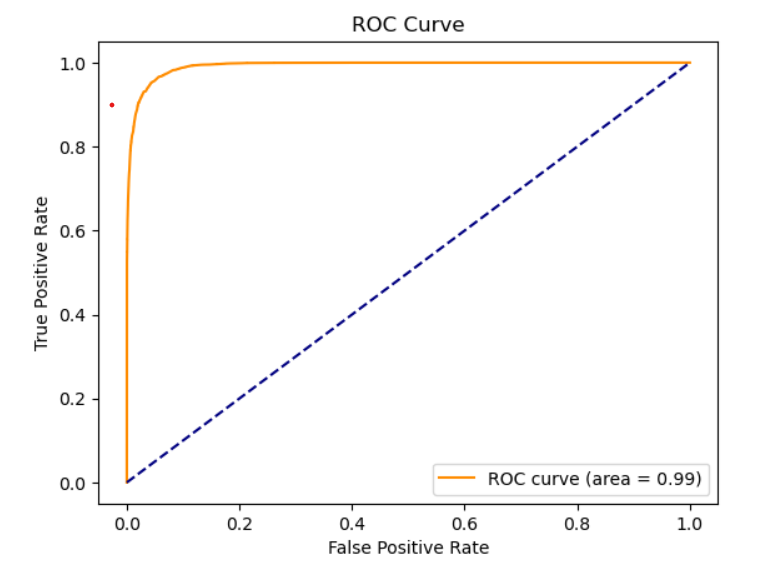

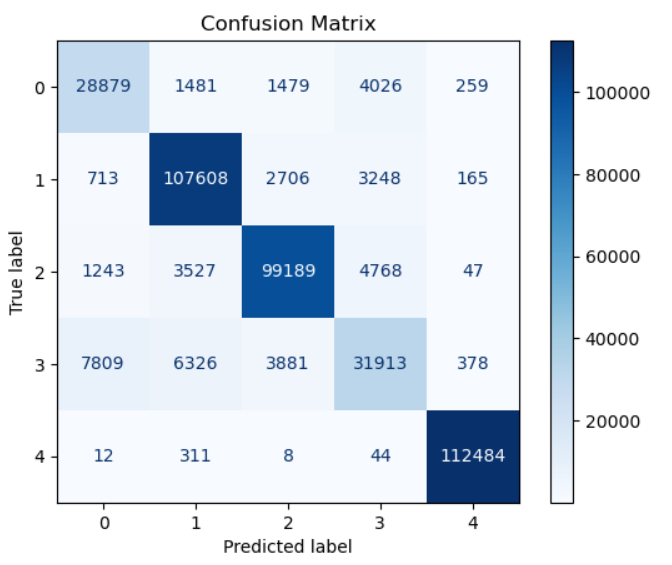

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set model to evaluation mode
model.eval()

# Initialize storage
all_preds = []
all_labels = []
all_probs = []

# Disable gradient calculations for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities

        # Store predictions, true labels, and probabilities
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Print classification report
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve and AUC for each class
n_classes = 5
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.show()

